# Determining Connectivity of Telecommunication Networks

We implemented the IP model using an optimization software called **`Gurobi`** alongside the Python package **`networkx`** to manipulate graphs. 
Here is a quick summary of the code, with a lot of comments to make the model implementation easier to read. For details on the model itself, and the structure, reasoning, and problem statement go to the paper, which is also available in [Github](https://github.com/Edelwy/dfg-project-math381). This write-up is meant purely to explain the implementation reasoning, the problem should be known to the reader prior to reading this.

First, we set up the environment and import packages. `networkx` is used for working with graphs and their elements, without having to implement the object structure ourselves. We used it mostly for working with nodes and edges and acquiring their neighbors, etc. The `gurobipy` package is crucial to our model as it is the core of solving the IP problem. It is widely used for linear programming optimization. It provides 2 main algorithms, the barrier, and the simplex method, but these are used for continuous models (real variable values), while we have integer programming (integer variable values). This problem is solved via a series of linear programming relaxations. For more details, refer to our paper and references.

In [122]:
import gurobipy as gp # Used for the IP model.
import numpy as np # Used for basic math operations.
from gurobipy import GRB # Used for setting the model to integer programing.
import networkx as nx # Used for graph manipulation.
import matplotlib.pyplot as plt # Used for vizualization of graphs.
import pandas as pd # Used for the data parsing.
import copy # We need this when creating paths.
import random # For vizualization.
import matplotlib.colors as mcolors # For vizualization.
import time # For timing the execution.

plt.rcParams['figure.dpi'] = 150 # Picture resoluton.

The company provided us with data in *Excel* files. There are 2 sheets in one file for one network. One is for nodes and one is for links. The first column of the **"nodes"** sheet is `str_name` which is used for labeling the nodes. The second column `ref_name` is the type of the node. There are 3 supported types: **PJ** is a manhole, **TS** is a splitter, and **OS** is a house.

The **"links"** sheet has 4 columns. The first one `span_name` is just a unique label for the edge. The second `to_str_name` is the end node and the third `from_str_name` is the start node (this is the order and layout of the data provided by the company). The fourth column is not provided by the company but has to be read from the corresponding picture they provide and is called `weights` short for edge weights.

We are using a `pandoc` package to read the data, so any of the [supported formats](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) can be used. We transform both sheets (data frames) into a matrix and then append the nodes to three lists, manhole, house, and splitter nodes. Edges go into one list.

In [123]:
# Function for reading the input.
# The input is in 2 spreadsheets one with links and one with nodes.
def parseInput(filepath):

    # We create a dataframe reading the input in a spreadsheed form.
    nodes_dataframe = pd.read_excel(filepath, sheet_name="nodes").to_numpy()
    edges_dataframe = pd.read_excel(filepath, sheet_name="links").to_numpy()

    house_nodes = [] # Initializing the list of nodes type house.
    manhole_nodes = [] # Initializing the list of nodes type manhole.
    splitter_nodes = [] # Initializing the list of nodes type splitte.
    edges = [] # Initializing the list of edges.

    # Reading the data from the spreadsheed and adding the nodes to 
    # their corresponding list, based on the type.
    for row in nodes_dataframe:
        node_type = row[1]
        if node_type == "PJ":
            manhole_nodes.append(row[0])
        if node_type == "TS":
            splitter_nodes.append(row[0])
        if node_type == "OS":
            house_nodes.append(row[0])
    
    # Adding the edges from the spreadshit to the list.
    for row in edges_dataframe:
        edges.append((row[1], row[2], row[3]))
        
    # Returning all four lists.
    return house_nodes, manhole_nodes, splitter_nodes, edges

This function creates a graph from the data we parsed earlier. The `networkx` graph structure does not know the distinction between the three types of nodes once we add them, this is why we need 3 separate lists. Mind that this is an undirected graph. We will modify it into a directed graph later.

In [124]:
# Function that creates a graph.
def createGraph(house_nodes, manhole_nodes, splitter_nodes, edges):
    G = nx.Graph() # Creating an empty networkx graph.

    # Adding all of the nodes.
    G.add_nodes_from(house_nodes) 
    G.add_nodes_from(manhole_nodes) 
    G.add_nodes_from(splitter_nodes) 

    # Adding all of the edges.
    for edge in edges: 
        G.add_edge(edge[0], edge[1], capacity=edge[2])
    return G

Now we have a few functions using `Gurobi` to define our model.

First, we define the variables.
The algorithm traverses each directed edge, to initialize all possible junction variables.  Each variable is stored in a dictionary, whose keys are pairs of edges that create a junction. If two edges share a common node, then the variable is added to our dictionary. We only allow for **integer** values because the number of cables is an integer, therefore the number of connected edges at a junction has to be an integer.

Then we have the constraints. For each `start` edge, the corresponding constraint is the sum of all variables that route to the `end` node. So if `start` is $ab \in E$ then `end` can be any edge $bc \in E$. Furthermore, we must also add the variables where the cable is wired from the `end` to the `start` edge, meaning $cb \in E$ routing to $ba$. We also ensure that every variable value is possible by adding this constraint to the model here.

We then add the **objective function** to the model, to minimize the number of paths that do not connect to a manhole. We simply iterate through all variables and add the ones that route from a subscriber to a subscriber through any node. Furthermore, we will prune the solutions with paths not connected to a manhole later, but this ensures that the solutions with a minimized number of *house-node-house* junctions are at the top of the solution pool. This is useful as a time optimization because we will need to prune fewer solutions before we find one that suits us. 

Finally, we evaluate our model and save several solutions equal to the `pool_solutions` value.

In [125]:
# Function that creates the variables.
def createVariables(model, G_directed, manhole_nodes): # We are working with a directed graph.
    x = {} # Initializing an empty dictionary for storing the variables.
    # Iterating through first edges in junctions.
    for start in G_directed.edges(): 
        # Iterating through last edges in junctions.
        for end in G_directed.edges(start): 
            # If these 2 edges have a common middle 
            # node we add them to the dictionary.
            if end[1] != start[0] and start[1] == end[0] and start[1] not in manhole_nodes:
                x[start, end] = \
                model.addVar(name=f"x[{start[0]} {start[1]} {end[1]}]", \
                            vtype=GRB.INTEGER)     
    return x

In [126]:
# Function for creating constraints.
# Creating constraints for the start cable bundles.
# x is the variable vector, G_directed is the directed graph.
def createConstraints(model, G_directed, x, weights): 
    # Fixed edge, the constraint of which we are using.
    for start in G_directed.edges():
        constr = 0 # Initialize the constraint.
        
        # All other possible junction from this fixed edge.
        for end in G_directed.edges(start):
            # Check if the variable is in the dictionary.
            if (start, end) in x:
                var_start = x[start, end]
                constr = constr + var_start # Add to the sum.
                model.addConstr(var_start >= 0) # Implicit constraint.
            # Check if the junction variable for the junction going
            # in the opposite direction is in the dictionary.
            if ((end[1], end[0]),(start[1], start[0])) in x:
                var_end = x[(end[1], end[0]),(start[1], start[0])]
                constr = constr + var_end # Add to the sum.
                model.addConstr(var_end >= 0) # Implicit constraint.

        # The sum of variables on the fixed edge must be equal to the
        # weight on that edge.
        constr = constr == weights[start]

        # In the case where the key is not in the dictionary,
        # The constraint will be 0 which equals false, we dont want that.
        if constr != False: 
            model.addConstr(constr)

In [127]:
# Setting the objective function.
def createObjective(model, house_nodes, x):
    min = 0 # Initialize the objective function.
    for (start, end), var in x.items(): # Iterate through variables.
        # If the start node of the junction and the end node of the junction
        # are both houses, then we add it to the sum.
        if start[0] in house_nodes and end[1] in house_nodes:
            min += var
    model.setObjective(min, sense = gp.GRB.MINIMIZE) 

In [128]:
# Finding the solution to our model.
def evaluateModel(model, solution_name, pool_solutions):
    model.setParam("OutputFlag", False) # We don't want an output printed.
    model.setParam(GRB.Param.PoolSearchMode, 2) # Mode for searching all optimal solutions.
    model.setParam(GRB.Param.PoolSolutions, pool_solutions) # Number of solutions saved.
    model.optimize() # Actually optimizing the model and finding the solution.

The next segment is for creating paths from junction variables in the solution. We need this to get the bigger picture. The value of a variable in a junction represents the number of cables connecting there, but this does not mean that we know how the paths are constructed yet. We have to stitch together the edges in these junctions in order to obtain the paths. 

First, we have a function that modifies the variable names so that the nodes are more accessible for later use when converting junction variables into paths. The next function deals with edge cases when there are no junction variables. There can be *manhole-node* paths consisting of just one edge that we need to take into account. Afterward, we have a function that determines whether we stitch the junction into the path or not. This procedure is described in detail below.

We have a `varsInPath` set that stores all the variables that have been stitched into a path already. This prevents duplicates. 
We have a fixed variable, and we iterate over all the other variables over and over again stitching them together until any more changes occur. Then we repeat the process for any other variable that is not in the `varsInPath` set. We stitch a junction to a path in 4 cases. If the junction has the same direction as the path we are creating, we stitch it if either the first edge in the junction matches the last in the path or the last edge in the junction matches the first one in the path. We add the edge that is not yet in the path (the one that is not matching). The second case is when the direction is opposite. Then either the last junction edge matches the last path edge or the first junction edge matches the first path edge. We have to continue this until all variables cannot connect anywhere because their value is 0.

One thing we have to be careful about when stitching the path is cycles. If we encounter a cycle we must decrease the junction variable value because this means we connected the cycle with this being the final junction connection, but we should not add the edge to the path because we don't want duplicates.

If a variable is stitched it does not go directly to the `varsInPath` set. Its value is decreased by one because that means one of the connections was stitched, but there could be more, so we have to keep that option. A variable is added to the set when its value reaches 0, meaning no more connections go through that junction.

In [129]:
# Function that changes name from "x[A B C]"" to "A B C".
def modifyVariableName(model):
    vars = {} # Empty dictionary of variables.
    for var in model.getVars():
        if var.xn != 0: # We only need junctions that connect.
            pathVarName = var.VarName.replace("x", "")
            pathVarName = pathVarName.replace("[", "").replace("]", "")
            vars[pathVarName] = int(var.xn)
    return vars

In [130]:
# Adding paths consisting of just 1 edge.
def addOneEdgePaths(G, paths, manhole_nodes, weights):
    # Going throught every manhole node and checking its neighbors.
    for node in manhole_nodes: 
        for neighbor in G.neighbors(node):
            # If the list of neighbors of the neighbor is just one element,
            # it means that the neighbor is a leaf node, so we have to add 
            # this one edge path to the paths list.
            next_neighbors = list(G.neighbors(neighbor))
            if len(next_neighbors) == 1:
                for i in range(weights[node, neighbor]):
                    paths.append([node, neighbor])
            # If we have 2 manholes connecting to eachother we also must add them.
            # There is no junctions to connect here.
            elif neighbor in manhole_nodes and [node, neighbor] not in paths:
                for i in range(weights[neighbor, node]):
                    paths.append([neighbor, node])

In [131]:
# Helper function that updates the variable when it is added to the path.
def updateVariable(vars, varKey, varsInPaths):
    vars[varKey] = vars[varKey] - 1 # Decrease number of connections in junction.
    if vars[varKey] == 0: # If there is no more options, we cannot use this anymore.
        varsInPaths.add(varKey)

In [132]:
# Helper function to determine if junction is in path.
# We have for different options.
# The last clause in the boolean expression is to work with cycles.
def addNodeToPath(path, nodes):
    # We add to the front of the path and the direction 
    # of the junction is the same as the path.
    if path[0] == nodes[1] and path[1] == nodes[2]:
        if nodes[0] != path[-2]:
            path.insert(0, nodes[0])
        return True
    # We add to the front of the path and the direction 
    # of the junction is the opposite as the path.
    elif path[0] == nodes[1] and path[1] == nodes[0]:
        if nodes[2] != path[-2]:
            path.insert(0, nodes[2])
        return True
    # We add to the end ont of the path and the direction 
    # of the junction is the same as the path.
    elif path[-2] == nodes[0] and path[-1] == nodes[1]:
        if nodes[2] != path[1]:
            path.append(nodes[2])
        return True
    # We add to the end ont of the path and the direction 
    # of the junction is the opposite as the path.
    elif path[-2] == nodes[2] and path[-1] == nodes[1]:
        if nodes[0] != path[1]:
            path.append(nodes[0])
        return True
    else: 
        return False

In [133]:
# A function that changes junction variables into paths.
def junctionsToPaths(model, G, manhole_nodes, weights):
    # This function changes the name from IP variable names, to
    # just nodes in the junction so it is more readable in the path.
    # Name goes from "x[A B C]"" to "A B C".
    vars = copy.deepcopy(modifyVariableName(model))
    varsInPaths = set() # So we don't create paths from variables we already added.
    paths = [] # We will save paths created here.
    ixVar = 0
    while varsInPaths != set(vars):
        firstVarKey = list(vars.keys())[ixVar]

        # Check if the fixed variable is already in some path.
        if firstVarKey not in varsInPaths:
            firstNodes = firstVarKey.split(" ") # First three nodes of the path.
            path = [firstNodes[0], firstNodes[1], firstNodes[2]] # Add them.
            updateVariable(vars, firstVarKey, varsInPaths)

            # We are going through the variables until there are changes made,
            # to the path. Once no new path is added, we can be sure the path is done.
            change = True
            while change:
                # We check for a change every iteration.
                change = False
                for varKey in vars.keys():
                    if(varKey == firstVarKey): 
                        continue
                    nodes = varKey.split(" ") # Getting all 3 nodes out of the junction.
                    # If this key is not used up already we can check whether,
                    # it matches the path we are building.
                    if varKey not in varsInPaths:
                        if addNodeToPath(path, nodes):
                            updateVariable(vars, varKey, varsInPaths)
                            change = True
            paths.append(path)
        # We move onto the next variable modulo the length of our list,
        # because we are looping through it.
        ixVar = (ixVar + 1) % len(vars)
    addOneEdgePaths(G, paths, manhole_nodes, weights)
    return paths

The next few functions are here for visualization. The first is a function that darkens the color of the edges used in the visualization of the solution.
The next one adds an edge to the multigraph while also bending it, so there is no overlap. Next, we have to create a multigraph that helps with the visualization of the disjoint paths. Each of the paths is represented in a **different color**.

The last 2 functions of this segment are using the `matplotlib` package. The manholes are square, the houses are circular and the splitters are in the shape of a diamond. The first function plots the undirected graph (input) where the number of cables in a bundle (edge) are presented as weights directly on that edge. The second one plots an undirected multigraph. The disjoint paths are colored each in a different color.

In [134]:
# A helper function to darken the colour of the edges, so the vizualization
# looks more readable.
def darken_color(color, amount = 0.8): # amount is percantage.
    rgb = mcolors.hex2color(color) # Changing the format.
    hsv = mcolors.rgb_to_hsv(rgb) # Changing the format again.
    new_value = hsv[2] * amount # Darkening the colour.
    new_rgb = mcolors.hsv_to_rgb((hsv[0], hsv[1], new_value)) # Changing back the format.
    new_hex = mcolors.rgb2hex(new_rgb) # Changing back the format again.
    return new_hex

In [135]:
# A helper function for adding the edges to the multigraph with colors and edge angles.
def add_edge(G, a, b, edgeColor = 0):
    # If the edge is already in the graph we must ad an angle to the edge, so there is no overlap.
    if (a, b) in G.edges: 
        max_rad = max(x[2]['rad'] for x in G.edges(data=True) if sorted(x[:2]) == sorted([a,b]))
    else: # If the edge isn't in the graph it can be straight.
        max_rad = 0
    G.add_edge(a, b, rad=max_rad+0.1, color=edgeColor) # Adding the edge with angle and colour.

In [136]:
# Creates a multigraph for the vizualization of the solution.
def createMultigraph(house_nodes, manhole_nodes, splitter_nodes, paths):
    G_multi = nx.MultiDiGraph() # Creates an empty graph.
    G_multi.add_nodes_from(house_nodes) 
    G_multi.add_nodes_from(manhole_nodes) 
    G_multi.add_nodes_from(splitter_nodes) 

    # Creating random colours so we can use them for showing paths.
    valid_colors = list(mcolors.CSS4_COLORS.values())  # List of valid color names
    random.shuffle(valid_colors)
    
    # Iterating through pairs of colours and paths, and adding them to the graph.
    for color, path in zip(valid_colors[:len(paths)], paths):
        for i in range(len(path) - 1): # Going over each edge in the path.
            add_edge(G_multi, path[i], path[i+1], darken_color(color))
    return G_multi

In [137]:
# Function that vizualizes the graph.
# The specifications are for prettier output.
def visualizeGraph(G, pos, house_nodes, manhole_nodes, splitter_nodes, weights, ax=None):
    nx.draw_networkx_nodes(G, pos, house_nodes, node_shape='o', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_nodes(G, pos, manhole_nodes, node_shape='s', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_nodes(G, pos, splitter_nodes, node_shape='D', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_edges(G ,pos, width=0.5, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_size=6, 
                                 font_family="serif", rotate=False, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=6, font_family="serif", ax=ax)

In [138]:
# Function that vizualizes the solution (multigraph).
# Each colour is a disjoint path.
# The specifications are for prettier output.
def visualizeMultigraph(G_multi, pos, house_nodes, manhole_nodes, splitter_nodes, ax=None):
    nx.draw_networkx_nodes(G_multi, pos, house_nodes, node_shape='o', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_nodes(G_multi, pos, manhole_nodes, node_shape='s', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    nx.draw_networkx_nodes(G_multi, pos, splitter_nodes, node_shape='D', 
                           edgecolors="black", linewidths=0.5, ax=ax)
    for edge in G_multi.edges(data=True):
        nx.draw_networkx_edges(G_multi, pos, 
                               edgelist=[(edge[0],edge[1])],
                               connectionstyle=f'arc3, rad = {edge[2]["rad"]}', 
                               width=1.5, arrowstyle="-", 
                               edge_color=edge[2]["color"], ax=ax)
    nx.draw_networkx_labels(G_multi, pos, font_size=6, font_family="serif", ax=ax)

This function checks a list of paths and returns `True` if all the paths have at least one manhole and `False` otherwise. We need this in the final step of our modeling because a user can specify whether we allow such paths or not. If not then we use this function to check if the condition is satisfied.

In [139]:
# Checking if the solution has paths with no manholes.
def checkPaths(paths):
    for path in paths:
        has_manhole = False
        for node in path:
            # If a path has a manhole we stop the search
            # in this path and move on to the next one.
            if "M" in node:
                has_manhole = True
                break
        # If a path doesn't have a manhole we return false,
        # therefore the solution is not satisfactory.
        if not has_manhole:
            return False
    # If all paths had at least one manhole, we return true.
    return True
        

This defines the **report of the solution**. We are reporting on the number of solutions saved by the model (not necessarily all, depending on the hyperparameter). We also state which of the saved solutions is being reported by stating its index and whether it satisfies the no-manhole paths rule. Execution time is the total time in seconds from the parsing of the data until the report. The visualization process is not being counted towards this time. If the user wants the junction variables (mathematical solution) printed, then they can do so with the `junction_variables` flag. Otherwise, only paths are being reported on (the interpretation).

In [140]:
# Writing up the report of the model to the user.
def writeReport(model, paths, solNo, execution_time, junction_variables):
    report = "REPORT:\n"
    report += f"Number of solutions found: {model.SolCount}\n"
    report += f"This is the {solNo}. solution the model found.\n"
    report += f"Does this solution have a manhole in every path: {checkPaths(paths)}\n"
    report += f"Execution time: {execution_time:.4f} seconds.\n"

    if junction_variables:
        report += "\nJUNCTION VARIABLES: \n"
        for var in model.getVars():
            if var.xn != 0:
                report += f"{var.VarName}: {var.xn}\n"

    report += "\nPATHS: \n"
    for i, path in enumerate(paths):
        paths_str = ", ".join(path)
        report += f"{i:3}: {paths_str}\n"
    print(report)
            

These are the **hyperparameters** that are available as `ip.py` arguments. You can tweak these to try out different options. 
- `input_file` specifies the location and name from which input data is read.
- `pool_number` is specifying how many solutions are saved.
- `visualize` flag is used if you want a picture representing the input and the solution as the program output. If you don't use this the `matplotlib` package is not necessary.
-`allow_all_paths` flag removes a restriction on the paths we allow in the solution of our model. The default does not allow paths with no manholes.
-`junction_variables` flag is used if you also want the junction variables from the IP model in the report.

In [141]:
# These are the parameters of the model that can be changed.
visualize = True 
allow_all_paths = False
junction_variables = False
input_file = "test-cases/33_Nodes.xlsx"
pool_solutions = 10

This is the cell that does it all. Before were just function definitions, this is the actual **script we are executing**.
First, we parse the input, then create a graph and make it bidirectional. We create a weights vector and a variable vector and add the constraints and the objective function. After all this, the model is evaluated and paths are created from the solution. If we are not allowing paths with no manholes, then solutions are checked until the first satisfactory solution is found. If there is none we return a solution, but warn the user that it is not optimal.

REPORT:
Number of solutions found: 10
This is the 0. solution the model found.
Does this solution have a manhole in every path: True
Execution time: 0.0270 seconds.

PATHS: 
  0: M1, S7, H3
  1: M6, S4, S3, S2, S1, M1
  2: M1, S1, S2, S6, H19
  3: M1, S1, S2, S6, H10
  4: M1, S1, S2, S6, M4
  5: M1, S1, S2, S3, H14
  6: H14, S3, S2, S1, M1
  7: M2, S3, S4, M6
  8: M2, S3, S4, M7
  9: M2, S3, S4, S5, M8
 10: M6, S4, S3, M2
 11: M6, S4, S3, M5
 12: M4, S6, S2, S1, M1
 13: H14, S3, S2, S1, M1
 14: M2, S3, S4, M7
 15: M7, S4, S3, M5
 16: M5, S3, S4, M7
 17: M1, H2
 18: M1, H1
 19: M2, H11
 20: M2, H12
 21: M2, H13
 22: M3, H4
 23: M3, H4
 24: M3, H5
 25: M3, H5
 26: M3, H6
 27: M3, H6
 28: M4, H8
 29: M4, H7
 30: M4, H9
 31: M4, H9
 32: M4, H9
 33: M5, H18
 34: M5, H17
 35: M5, H16
 36: M5, H15
 37: M6, H20
 38: M6, H20
 39: M6, H20
 40: M6, H20
 41: M6, H20



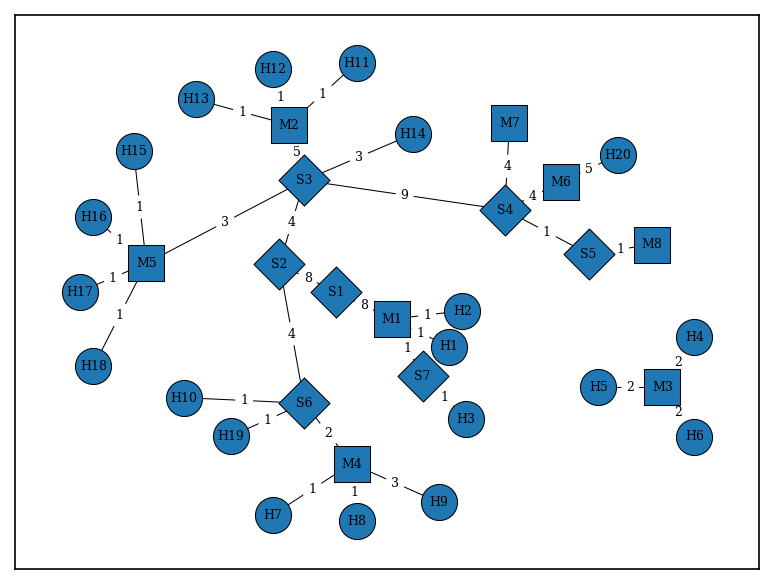

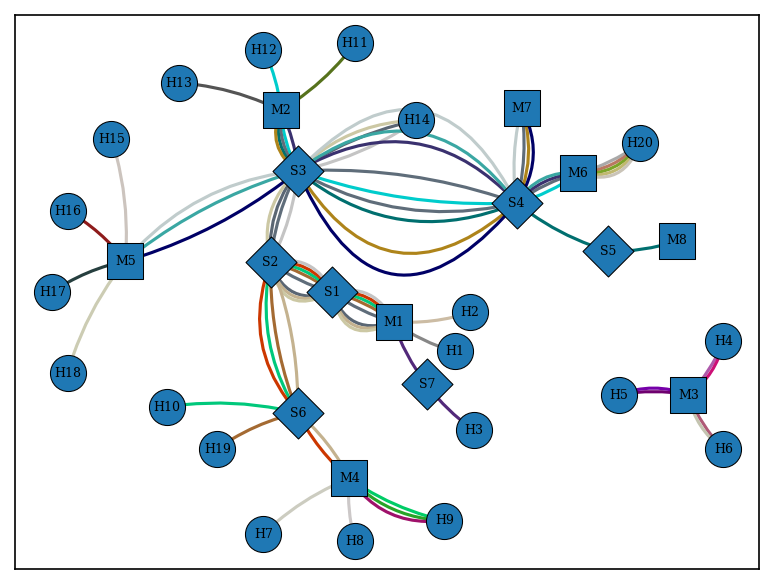

In [142]:
# Start the timer.
start_time = time.time()

# First we parse the input file provided in the arguments.
# From that we get nodes of type house, splitter and manhole.
# We also get edges and edge weights.
house_nodes, manhole_nodes, splitter_nodes, edges = parseInput(input_file)

# Then we create an undirected graph using these nodes and edges.
G = createGraph(house_nodes, manhole_nodes, splitter_nodes, edges)
G_directed = G.to_directed() # We also create a directed version of the graph.
# We extract the weights vector for all edges (directed).
weights = nx.get_edge_attributes(G_directed, 'capacity')
model = gp.Model("DFG") # Initialiting the model.

x = createVariables(model, G_directed, manhole_nodes) # Creating the variables vector.
# Adding constraints to the model.
createConstraints(model, G_directed, x, weights) 
createObjective(model, house_nodes, x) # Adding the objective function to the model.
evaluateModel(model, "DFG", pool_solutions = pool_solutions) # Evaluating the solution.

if model.SolCount == 0:
    print("No solution was found for this model.")
else:
    paths = junctionsToPaths(model, G, manhole_nodes, weights) # Getting the paths of the model.
    # If we don't want paths with house-node-house paths, we iterate through
    # the solutions and find the first one that satisfies this constraint.
    # If we dont find any we give a warning, that perhaps we should either save more
    # solutions or lose the constraint.
    solution_index = 0
    if not checkPaths(paths) and not allow_all_paths:
        for i in range(1, model.SolCount):
            model.setParam(GRB.Param.SolutionNumber, i)
            paths = junctionsToPaths(model, G, manhole_nodes, weights)
            path_check = checkPaths(paths)
            if path_check:
                solution_index = i
                break
            if not path_check and i == model.SolCount - 1:
                print("No solution with a manhole in every path found. \
                    Printing last solution saved. If this is not satisfactory \
                    consider increasing the number of solutions saved.")
                
    # Getting the exection time.
    end_time = time.time()
    execution_time = end_time - start_time

    #Printing out the report.
    writeReport(model, paths, solution_index, execution_time, junction_variables)

# Vizualizing the input as an undirected graph and a solution as a multigraph.
if visualize:
    pos=nx.spring_layout(G, k=0.15, iterations=20)
    visualizeGraph(G, pos, house_nodes, manhole_nodes, splitter_nodes, weights)
    plt.show()
    if model.SolCount != 0:
        G_multi = createMultigraph(house_nodes, manhole_nodes, splitter_nodes, paths)
        visualizeMultigraph(G_multi, pos, house_nodes, manhole_nodes, splitter_nodes)
        plt.show()